In [2]:
import networkx as nx
import numpy as np
from scipy.special import logsumexp
import seaborn as sns
import matplotlib.pyplot as plt
from treesample.util import laplacian

from treesampling.algorithms.castaway_legacy import _castaway_rst_log, _castaway_rst_plain, tree_to_list
from treesampling.algorithms import wilson_rst, kirchoff_rst, colbourn_rst, CastawayRST
from treesampling.algorithms.wilson import wilson_rst_from_matrix
from treesampling.utils.graphs import graph_weight, tree_to_newick, tree_weight

# from treesample.colbourn import ColbournSample
from treesample.wilson import WilsonSample

In [3]:

matrix = np.array([
    [   -np.inf    , -174.769, -174.769, -244.775, -249.29 , -276.033, -240.241],
    [   -np.inf    ,    -np.inf   ,  -56.238, -124.203, -143.693, -174.44 , -145.639],
    [   -np.inf    ,  -59.999,    -np.inf   ,  -18.449,  -56.7  , -107.202,  -51.118],
    [   -np.inf    , -133.159,    0.   ,    -np.inf   , -126.356, -155.468, -123.161],
    [   -np.inf    , -141.243,  -39.487, -117.625,    -np.inf   , -105.354,  -60.438],
    [   -np.inf    , -177.913,  -78.955, -150.078,  -84.43 ,    -np.inf   , -102.489],
    [   -np.inf    , -131.7  ,  -25.589, -115.073,  -59.796, -109.966,    -np.inf   ]
])
print(logsumexp(matrix, axis=0))
matrix[0, [1, 2]] = -10
norm_matrix = matrix - logsumexp(matrix, axis=0, keepdims=True)
norm_matrix[:, 0] = -np.inf

[           -inf -5.99990000e+01  7.70605801e-12 -1.84490000e+01
 -5.66557633e+01 -1.05199149e+02 -5.11179104e+01]


/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_78488/1737195529.py:12: RuntimeWarning: invalid value encountered in subtract
  norm_matrix = matrix - logsumexp(matrix, axis=0, keepdims=True)


In [9]:
for i in range(matrix.shape[0]):
    print(*tuple(str(-matrix[i, j]) + ',' for j in range(matrix.shape[1])))

inf, 174.769, 174.769, 244.775, 249.29, 276.033, 240.241,
inf, inf, 56.238, 124.203, 143.693, 174.44, 145.639,
inf, 59.999, inf, 18.449, 56.7, 107.202, 51.118,
inf, 133.159, -0.0, inf, 126.356, 155.468, 123.161,
inf, 141.243, 39.487, 117.625, inf, 105.354, 60.438,
inf, 177.913, 78.955, 150.078, 84.43, inf, 102.489,
inf, 131.7, 25.589, 115.073, 59.796, 109.966, inf,


<Axes: >

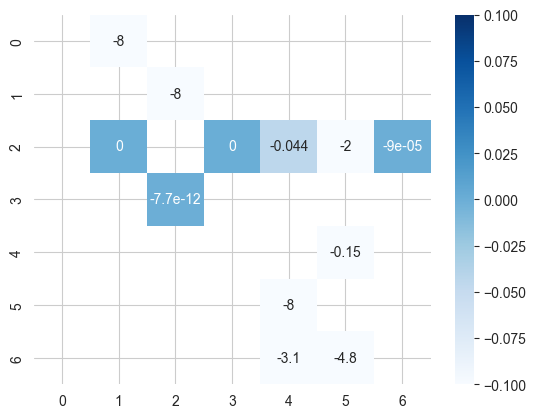

In [5]:
tau = -8
clean_matrix = norm_matrix.copy()
rows_to_modify = np.all(clean_matrix < -8, axis=1)
max_indices = np.argmax(clean_matrix[rows_to_modify], axis=1)
clean_matrix[rows_to_modify, max_indices] = -8
clean_matrix[clean_matrix < -8] = -np.inf
sns.heatmap(clean_matrix, annot=clean_matrix, cmap='Blues')
# remove weights that are below
# clean_matrix[0, 1 ] = -np.inf
# clean_matrix[0, 2 ] = -8 # this confuses the algorithm and makes many samples with arc 0->2, and then these
# are proven to be less probable

Below we analyse the MST of the matrix. First, let's force 0->1

In [6]:
# if taking the maximum to choose the out arc from 0, what would be the weight?
graph01 = matrix.copy()
graph01[0, 2:] = -np.inf
mst01 = nx.maximum_spanning_arborescence(nx.from_numpy_array(np.exp(graph01), create_using=nx.DiGraph()), attr='weight', preserve_attrs=True)
tree_to_newick(mst01), np.sum([matrix[u, v] for u, v in mst01.edges()])

('(((2)3,4,5,6)1)0', -762.744)

Then, we remove constraints and observe that the MST has lower weight: does this mean that the MST is not the best tree?

In [7]:
# check which arc goes out from 0 using the mst
mst = nx.maximum_spanning_arborescence(nx.from_numpy_array(np.exp(matrix), create_using=nx.DiGraph()), attr='weight', preserve_attrs=True)
tree_to_newick(mst), np.sum([matrix[u, v] for u, v in mst.edges()])

('(1,(2)3,4,5,6)0', -1185.108)

In [8]:
sample_size = 10000
tree_counts = {} # nwk_tree: (count, weight)
castaway = CastawayRST(clean_matrix, root=0, trick=False, log_probs=True)
for i in range(sample_size):

    tree = castaway.sample_tree()
    # tree = _castaway_rst_log(matrix, root=0, trick=False)
    # tree = wilson_rst_from_matrix(clean_matrix, log_probs=True)
    # tree = colbourn_rst(clean_matrix, root=0, log_probs=True)
    nwk_tree = tree_to_newick(tree)
    tree_w = sum(matrix[u, v] for u, v in tree.edges())
    tree_norm_w = sum(norm_matrix[u, v] for u, v in tree.edges())
    if nwk_tree not in tree_counts:
        print(tree.edges, tree_w, tree_norm_w)
        tree_counts[nwk_tree] = (1, tree_w, tree_norm_w)
    else:
        count, weight, norm_weight = tree_counts[nwk_tree]
        if not np.isclose(weight, tree_w) or not np.isclose(norm_weight, tree_norm_w):
            print(tree.edges)
            print([matrix[u, v] for u, v in tree.edges()])
            print(f"Error: {nwk_tree} has different weights {weight} and {tree_w}")
        tree_counts[nwk_tree] = (count + 1, weight, norm_weight)

[(0, 1), (1, 2), (2, 3), (2, 4), (2, 6), (4, 5)] -462.628 -171.20717724891472
[(0, 1), (1, 2), (2, 3), (2, 4), (2, 5), (2, 6)] -464.476 -173.05517724891473
[(0, 1), (1, 2), (2, 3), (2, 6), (6, 4), (4, 5)] -465.724 -174.30317724891472
[(0, 1), (1, 2), (2, 3), (2, 5), (2, 6), (6, 4)] -467.572 -176.15117724891473
[(0, 1), (1, 2), (2, 3), (2, 4), (2, 6), (6, 5)] -467.24 -175.81917724891474
[(0, 1), (1, 2), (2, 3), (2, 6), (6, 4), (6, 5)] -470.336 -178.91517724891474
[(0, 1), (1, 2), (2, 3), (2, 5), (2, 6), (5, 4)] -492.206 -200.78517724891475
[(0, 1), (1, 2), (2, 3), (2, 6), (5, 4), (6, 5)] -494.97 -203.54917724891476


In [9]:
sorted_trees = sorted(tree_counts.items(), key=lambda x: x[1][0], reverse=True)
empirical_freqs = np.array([count for _, (count, _, _) in sorted_trees], dtype=float)
empirical_freqs /= sample_size
expected_freqs = np.array([weight for _, (_, _, weight) in sorted_trees])
expected_freqs = np.exp(expected_freqs - logsumexp(expected_freqs))
print(empirical_freqs), print(np.sum(empirical_freqs))
print(expected_freqs), print(np.sum(expected_freqs))


[8.191e-01 1.267e-01 3.910e-02 8.500e-03 5.700e-03 6.000e-04 2.000e-04
 1.000e-04]
1.0
[8.19478072e-01 1.29110373e-01 3.70647966e-02 8.13900259e-03
 5.83963118e-03 3.68125134e-04 1.16943248e-13 7.37199791e-15]
0.999999999999993


(None, None)

/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_44954/4279256024.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


Text(0.5, 1.0, 'Empirical frequencies of trees')

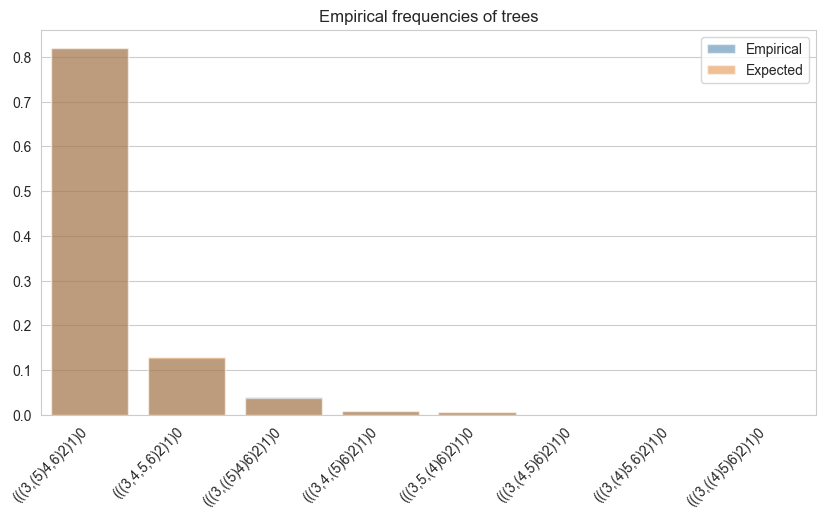

In [10]:
# barplot
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=[t for t, _ in sorted_trees], y=empirical_freqs, ax=ax, alpha=0.5, label='Empirical')
sns.barplot(x=[t for t, _ in sorted_trees], y=expected_freqs, ax=ax, alpha=0.5, label='Expected')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Empirical frequencies of trees')


/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_20372/2136383907.py:2: RuntimeWarning: invalid value encountered in subtract
  norm_matrix = matrix - logsumexp(matrix, axis=0, keepdims=True)


<Axes: >

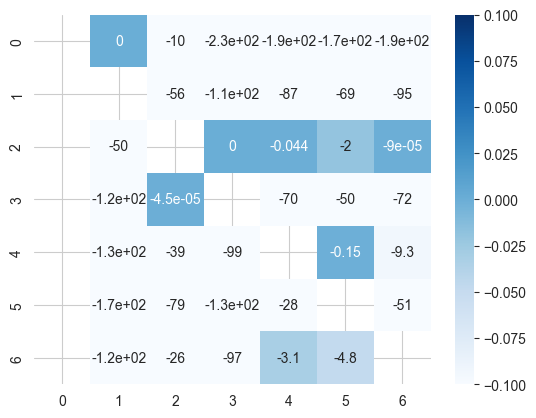

In [15]:
# normalize and try use wilson
norm_matrix = matrix - logsumexp(matrix, axis=0, keepdims=True)
norm_matrix[:, 0] = -np.inf
norm_matrix[np.diag_indices(norm_matrix.shape[0])] = -np.inf
sns.heatmap(norm_matrix /100,  annot=norm_matrix, cmap='Blues')

In [ ]:
norm_matrix[0, 1:] = -np.inf

[[ 1.00000000e+00  4.53978687e-05  5.10348789e-99  2.18783197e-84
   6.42393631e-75  7.32631828e-83]
 [-1.93067956e-22  9.99954602e-01 -1.00000000e+00 -9.56727447e-01
  -1.34950004e-01 -9.99910394e-01]
 [-3.25631120e-54 -9.99954602e-01  1.00000000e+00 -5.36502564e-31
  -1.47406094e-22 -5.15327980e-32]
 [-1.00435978e-57 -7.09568090e-18 -8.48028529e-44  1.00000000e+00
  -8.56542869e-01 -8.96058805e-05]
 [-1.19209443e-73 -5.13167879e-35 -6.82734174e-58 -8.66567207e-13
   1.00000000e+00 -4.89575023e-23]
 [-1.40075297e-53 -7.70581869e-12 -1.08825327e-42 -4.32725529e-02
  -8.50712772e-03  1.00000000e+00]]
condition number:  7.788190438963578e+16


<Axes: >

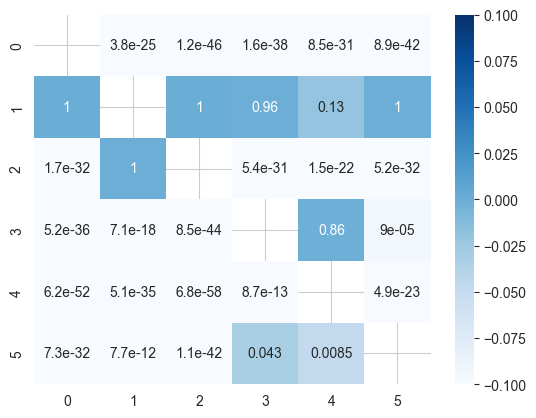

In [16]:
norm_matrix_minor = norm_matrix[1:, 1:] - logsumexp(norm_matrix[1:, 1:], axis=0)
L = laplacian(np.exp(norm_matrix[1:, 1:]), np.exp(norm_matrix[0, 1:]))
print(L)
print("condition number: ", np.linalg.cond(L))
sns.heatmap(norm_matrix_minor / 100, annot=np.exp(norm_matrix_minor), cmap='Blues')

In [11]:
logsumexp(norm_matrix, axis=1)

array([-1.14770000e+02, -5.62379977e+01,  1.40893312e+00, -7.70605801e-12,
       -1.54746304e-01, -2.77742367e+01, -2.96075747e+00])

In [7]:
# colbourn
sample_size = 1000
tree_counts_colbourn = {} # nwk_tree: (count, weight)
for i in range(sample_size):
    graph = nx.from_numpy_array(np.exp(norm_matrix), create_using=nx.DiGraph())
    tree = colbourn_rst(graph, root=0)
    nwk_tree = tree_to_newick(tree)
    tree_w = sum(matrix[u, v] for u, v in tree.edges())
    if nwk_tree not in tree_counts:
        tree_counts_colbourn[nwk_tree] = (1, tree_w)
    else:
        count, weight = tree_counts_colbourn[nwk_tree]
        if not np.isclose(weight, tree_w):
            print(tree.edges)
            print([matrix[u, v] for u, v in tree.edges()])
            print(f"Error: {nwk_tree} has different weights {weight} and {tree_w}")
        tree_counts_colbourn[nwk_tree] = (count + 1, weight)

/Users/zemp/PycharmProjects/treesampling/src/treesampling/utils/math.py:50: RuntimeWarning: invalid value encountered in divide
  return arr / np.sum(arr, axis=axis, keepdims=True)
/Users/zemp/PycharmProjects/treesampling/src/treesampling/algorithms/__init__.py:142: RuntimeWarning: invalid value encountered in divide
  marginals /= np.sum(marginals)


ValueError: probabilities contain NaN

# Verification
Try to use Wilson on a slightly different matrix

In [8]:
tree1, tree2 = sorted(sorted_trees, key=lambda x: x[1][1], reverse=True)[:2]
tree1, tree2

(('(((3,(5)4,6)2)1)0', (686, -462.628, -463.3211471902846)),
 ('(((3,4,5,6)2)1)0', (957, -464.476, -465.1691471902846)))

/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_9031/2478534412.py:11: RuntimeWarning: invalid value encountered in divide
  norm_matrix2 = matrix2 / matrix2.sum(axis=0, keepdims=True)


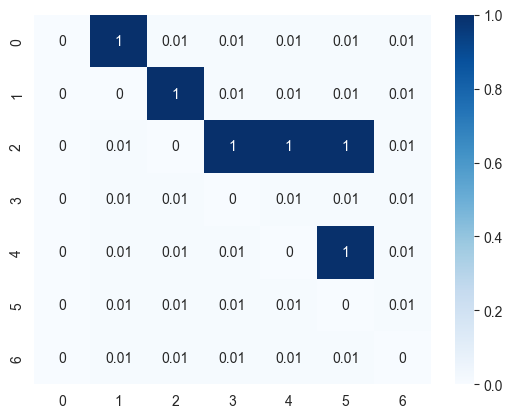

In [9]:
hh = 1. # high weight
ww = 0.01  # weak weight
matrix2 = np.array([[0, hh, ww, ww, ww, ww, ww],
                   [0, 0, hh, ww, ww, ww, ww],
                   [0, ww, 0, hh, hh, hh, ww],
                   [0, ww, ww, 0, ww, ww, ww],
                   [0, ww, ww, ww, 0, hh, ww],
                   [0, ww, ww, ww, ww, 0, ww],
                   [0, ww, ww, ww, ww, ww, 0]])
sns.heatmap(matrix2, annot=True, cmap='Blues')
norm_matrix2 = matrix2 / matrix2.sum(axis=0, keepdims=True)


In [12]:
tree_counts_casta = {} # nwk_tree: (count, weight)
for i in range(10000):
    tree = tuple(wilson_rst_from_matrix(norm_matrix2))
    tree_w = np.prod([norm_matrix2[u, v] for v, u in enumerate(tree) if u != -1])
    if tree not in tree_counts_casta:
        tree_counts_casta[tree] = (1, tree_w)
    else:
        count, weight = tree_counts_casta[tree]
        if not np.allclose(weight, tree_w):
            arcs = [(u, v) for u, v in tree if u != -1]
            print(arcs)
            print([matrix2[u, v] for u, v in arcs])
            print(f"Error: {tree} has different weights {weight} and {tree_w}")
        tree_counts_casta[tree] = (count + 1, weight)


In [13]:
sorted_trees = sorted(tree_counts_casta.items(), key=lambda x: x[1][0], reverse=True)
empirical_freqs = np.array([count for _, (count, _) in sorted_trees], dtype=float)
empirical_freqs /= sample_size
expected_freqs = np.array([weight for _, (_, weight) in sorted_trees])
expected_freqs = np.exp(expected_freqs - logsumexp(expected_freqs))
print(empirical_freqs), print(np.sum(empirical_freqs))
print(expected_freqs), print(np.sum(expected_freqs))


[0.763 0.761 0.757 0.752 0.75  0.748 0.732 0.732 0.731 0.714 0.702 0.683
 0.015 0.014 0.013 0.013 0.013 0.013 0.012 0.012 0.012 0.012 0.012 0.012
 0.012 0.012 0.012 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011
 0.011 0.011 0.011 0.011 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.009 0.009 0.009 0.009 0.009 0.009 0.009 0.008
 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.008
 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.007 0.007 0.007 0.007
 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007
 0.007 0.007 0.007 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006
 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006
 0.006 0.006 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.004 0.004 0.004 0.004 0.004
 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.003 0.003 0.003 0.003 0.003
 0.003 0.003 0.003 0.003 0.002 0.001 0.001 0.001 0.0

(None, None)

/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_9031/3548800611.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


Text(0.5, 1.0, 'Empirical frequencies of trees')

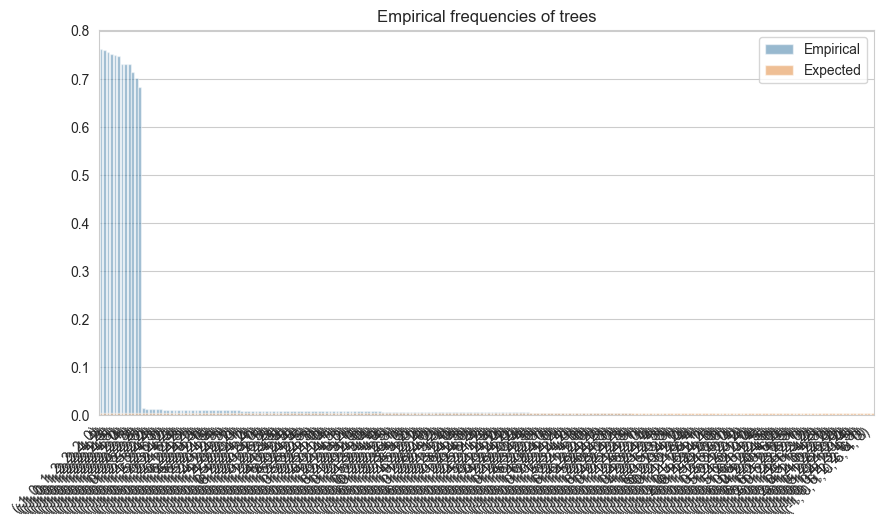

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=[str(t) for t, _ in sorted_trees], y=empirical_freqs, ax=ax, alpha=0.5, label='Empirical')
sns.barplot(x=[str(t) for t, _ in sorted_trees], y=expected_freqs, ax=ax, alpha=0.5, label='Expected')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Empirical frequencies of trees')


# Uniform matrix small instance


In [2]:

def laplacian(A, r):
    """
    Root-weighted Laplacian of Koo et al. (2007)
    A is the adjacency matrix and r is the root weight
    """
    L = -A + np.diag(np.sum(A, 0))
    L[0] = r
    return L


In [3]:
from treesampling.utils.graphs import tuttes_tot_weight

K = 4
N = 100000
# random matrix
W = np.random.uniform(0, 1, size=(K, K))
np.fill_diagonal(W, 0)
# prepare normalization factor
A = np.copy(W)
L = laplacian(A[1:, 1:], A[0, 1:])
new_det = np.linalg.det(L)
graph = nx.from_numpy_array(W, create_using=nx.DiGraph)
tuttes_det = tuttes_tot_weight(graph, root=0)
print(f"tuttes det: {tuttes_det}")
Z = tuttes_det
print(f"chosen tot weight Z: {Z}")

W = np.log(W)

tuttes det: 2.1088447631077583
chosen tot weight Z: 2.1088447631077583


/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_10743/3205444248.py:18: RuntimeWarning: divide by zero encountered in log
  W = np.log(W)


In [4]:
# gather sample
dist = {}
real_prob = {}
castaway = CastawayRST(W, root=0, trick=False, log_probs=True)
for _ in range(N):
    # tree_nx = _castaway_rst_log(W, 0, trick=False)
    # tree = tree_to_list(tree_nx)
    # tree = tuple(wilson_rst_from_matrix(W, log_probs=True))
    tree = tuple(castaway.sample_tree_as_list())
    if tree not in dist:
        real_prob[tree] = np.exp(sum([W[u, v] for v, u in enumerate(tree) if u != -1])) / Z
        dist[tree] = 0
    dist[tree] += 1 / N



In [5]:
# gather sample (wilson)
dist_wilson = {}
real_prob_wilson = {}
for _ in range(N):
    tree = tuple(wilson_rst_from_matrix(W, log_probs=True))
    if tree not in dist_wilson:
        real_prob_wilson[tree] = np.exp(sum([W[u, v] for v, u in enumerate(tree) if u != -1])) / Z
        dist_wilson[tree] = 0
    dist_wilson[tree] += 1 / N


/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_10743/1413920175.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')
/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_10743/1413920175.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')


Text(0.5, 0.98, 'Test for accuracy in log-probabilities')

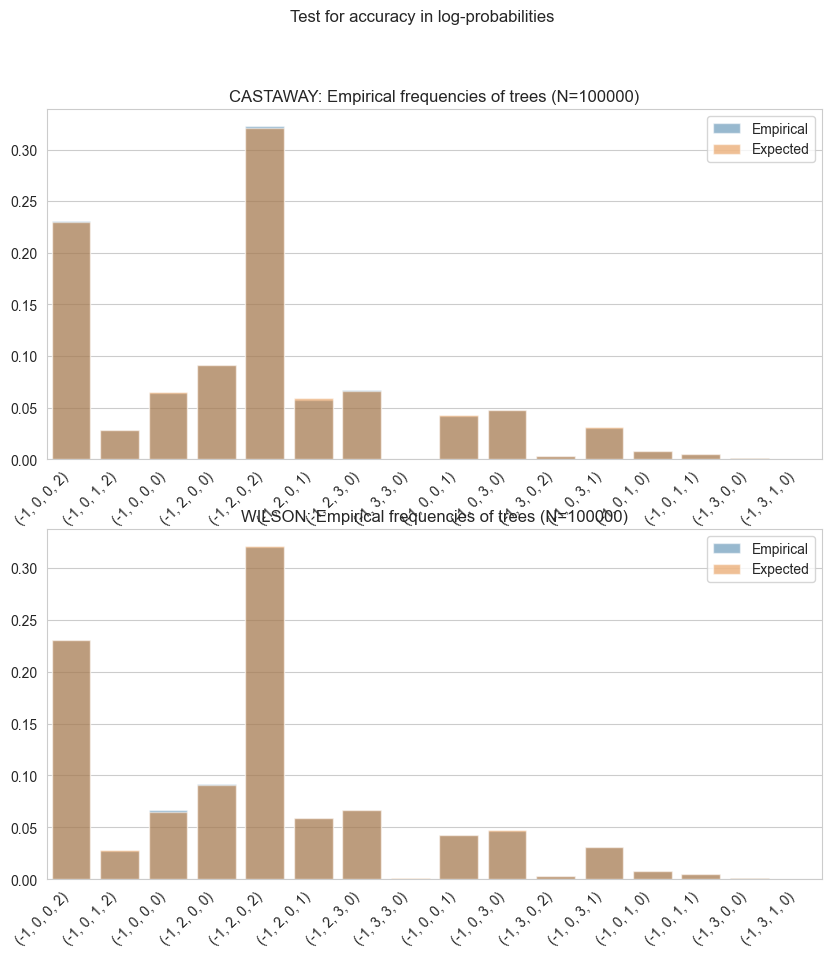

In [7]:
# plot
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
sns.barplot(x=list(str(k) for k in dist), y=list(dist.values()), ax=axs[0], alpha=0.5, label='Empirical')
sns.barplot(x=list(str(k) for k in dist), y=list(real_prob[k] for k in dist), ax=axs[0], alpha=0.5, label='Expected')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')
axs[0].set_title(f'CASTAWAY: Empirical frequencies of trees (N={N})')

sns.barplot(x=list(str(k) for k in dist), y=list(dist_wilson[k] for k in dist), ax=axs[1], alpha=0.5, label='Empirical')
sns.barplot(x=list(str(k) for k in dist), y=list(real_prob_wilson[k] for k in dist), ax=axs[1], alpha=0.5, label='Expected')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')
axs[1].set_title(f'WILSON: Empirical frequencies of trees (N={N})')
fig.suptitle("Test for accuracy in log-probabilities")



In [8]:
from treesampling.utils.graphs import tuttes_tot_weight

K = 4
N = 100000
# random matrix
W = np.random.uniform(0, 1, size=(K, K))
np.fill_diagonal(W, 0)
# prepare normalization factor
A = np.copy(W)
L = laplacian(A[1:, 1:], A[0, 1:])
new_det = np.linalg.det(L)
graph = nx.from_numpy_array(W, create_using=nx.DiGraph)
tuttes_det = tuttes_tot_weight(graph, root=0)
print(f"tuttes det: {tuttes_det}")
Z = tuttes_det
print(f"chosen tot weight Z: {Z}")

tuttes det: 1.6449274159719072
chosen tot weight Z: 1.6449274159719072


In [9]:
# gather sample
dist = {}
real_prob = {}
castaway = CastawayRST(W, root=0, trick=False, log_probs=False)
for _ in range(N):
    tree = tuple(castaway.sample_tree_as_list())
    if tree not in dist:
        real_prob[tree] = tree_weight(tree, W) / Z
        dist[tree] = 0
    dist[tree] += 1 / N



In [10]:
# gather sample (wilson)
dist_wilson = {}
real_prob_wilson = {}
for _ in range(N):
    tree = tuple(wilson_rst_from_matrix(W, log_probs=False))
    if tree not in dist_wilson:
        real_prob_wilson[tree] = tree_weight(tree, W) / Z
        dist_wilson[tree] = 0
    dist_wilson[tree] += 1 / N


In [11]:
print("castaway accuracy: ", sum([1 if np.isclose(dist[k], real_prob[k], rtol=0.1) else 0 for k in dist]) / len(dist))
print("wilson accuracy: ", sum([1 if np.isclose(dist_wilson[k], real_prob_wilson[k], rtol=0.1) else 0 for k in dist]) / len(dist))

castaway accuracy:  1.0
wilson accuracy:  1.0


/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_10743/3719723483.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')
/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_10743/3719723483.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')


Text(0.5, 0.98, 'Test for accuracy (non-log-probabilities)')

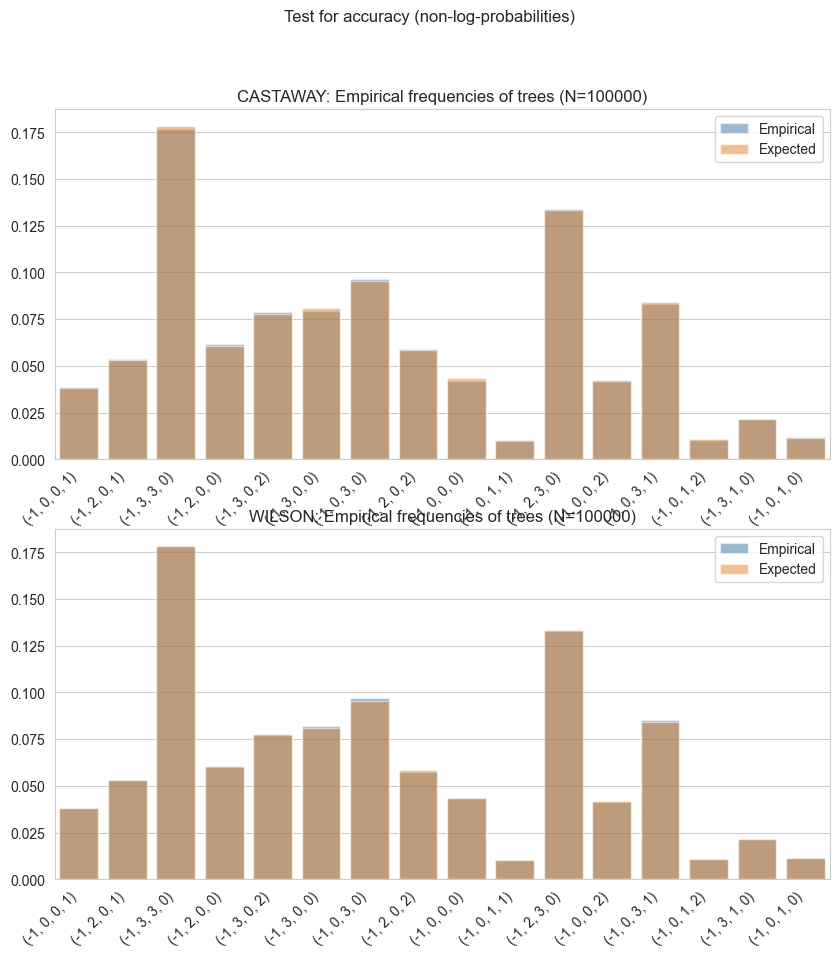

In [13]:
# plot
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
sns.barplot(x=list(str(k) for k in dist), y=list(dist[k] for k in dist), ax=axs[0], alpha=0.5, label='Empirical')
sns.barplot(x=list(str(k) for k in dist), y=list(real_prob[k] for k in dist), ax=axs[0], alpha=0.5, label='Expected')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')
axs[0].set_title(f'CASTAWAY: Empirical frequencies of trees (N={N})')

sns.barplot(x=list(str(k) for k in dist), y=list(dist_wilson[k] for k in dist), ax=axs[1], alpha=0.5, label='Empirical')
sns.barplot(x=list(str(k) for k in dist), y=list(real_prob_wilson[k] for k in dist), ax=axs[1], alpha=0.5, label='Expected')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')
axs[1].set_title(f'WILSON: Empirical frequencies of trees (N={N})')
fig.suptitle("Test for accuracy (non-log-probabilities)")



## Tempering
Find what tempering is required for the laplacian inverse to be correctly computed

In [5]:
from treesampling.algorithms.castaway import importance_sample

for temp in [10, 50, 100, 500]:
    print(f"temp: {temp}")
    trees = importance_sample(matrix, 1000, temp=temp, log_probs=True)
    tot_weight = logsumexp([w for w in trees.values()])
    for tree in sorted(trees, key=trees.get, reverse=True):
        freq = trees[tree] - tot_weight
        print(f"tree: {tree} ({np.exp(freq)} | {freq})")


temp: 10
tree: (-1, 0, 1, 2, 2, 4, 2) (0.7677846973190955 | -0.2642459271700659)
tree: (-1, 0, 1, 2, 2, 2, 2) (0.14066874499945928 | -1.9613474788457097)
tree: (-1, 0, 1, 2, 6, 4, 2) (0.045224861903593254 | -3.0961083012467725)
tree: (-1, 2, 0, 2, 2, 4, 2) (0.0245681512124184 | -3.706304341009968)
tree: (-1, 0, 1, 2, 2, 6, 2) (0.009809576698342527 | -4.6243961563519065)
tree: (-1, 0, 1, 2, 6, 2, 2) (0.006079810608986391 | -5.102781733326992)
tree: (-1, 2, 0, 2, 2, 2, 2) (0.003999059156706857 | -5.521696156351936)
tree: (-1, 2, 0, 2, 6, 4, 2) (0.000962119830683397 | -6.946371550936078)
tree: (-1, 0, 1, 2, 6, 6, 2) (0.0004804378958330977 | -7.640812586953928)
tree: (-1, 2, 0, 2, 6, 2, 2) (0.00017897513293083482 | -8.628263683948205)
tree: (-1, 2, 0, 2, 2, 6, 2) (0.00015479713992991293 | -8.773395072884284)
tree: (-1, 0, 1, 2, 2, 4, 4) (6.406912136794826e-05 | -9.655548036033906)
tree: (-1, 0, 1, 2, 2, 2, 4) (1.1775143930956654e-05 | -11.349519694700689)
tree: (-1, 2, 0, 2, 6, 6, 2) (8.98

# Conductance definitions
We explore two different definitions of conductance on directed weighted graphs with respect to a (arc-reversed) random walk.

One is the Cheeger constant, which is defined as:
$$
\Phi(G) = \min_{S \subset V} \frac{\sum_{u \in S, v \in \bar{S}} \tilde w_{vu}}{\min(\sum_{u, v \in S} \tilde w_{vu}, \sum_{u, v \in \bar{S}} \tilde w_{vu})}
$$
where $\tilde w_{v, u}$ is the weight of the arc $(v, u)$, and $S$ is a subset of $V$. The bar notation denotes the complement of $S$. The Cheeger constant is the smallest conductance over all possible cuts of the graph.

The other is the customized conductance, defined by Jens:
$$
\Phi_J(G) = \min_{S \subset V} \frac{\max_{\substack{u\in S}} \sum_{v \in \bar{S}} \tilde w_{vu}}{\min_{\substack{u \in S}} \sum_{v \in S} \tilde w_{vu}}
$$

We compute both quantities for the matrix of interest and compare the subsets.


In [42]:
from treesampling.utils.graphs import mat_minor
from treesampling import StableOp
import itertools


# Cheeger constant
def cheeger_constant(matrix, root=None, log_probs=False):
    """
    Compute the Cheeger constant of a directed graph
    """
    op = StableOp(log_probs=log_probs)
    if root is not None:
        matrix = mat_minor(matrix, root, root)
    n = matrix.shape[0]
    component = None
    cheeger = np.inf
    max_out, min_in = 0, np.inf
    for s_size in range(2, n-1):
        for s in itertools.combinations(range(n), s_size):
            # print(s)
            s = set(s)
            s_bar = set(range(n)) - s
            num = op.add([matrix[v, u] for v in s_bar for u in s])
            denom = min(op.add([matrix[v, u] for v in s for u in s if v != u]),
                        op.add([matrix[v, u] for v in s_bar for u in s_bar if v != u]))
            cheeger_ = op.div(num, denom)
            if cheeger_ < cheeger:
                max_out, min_in = num, denom
                cheeger = cheeger_
                component = s
    return cheeger, [c + (0 if c < root else 1) for c in component], max_out, min_in

# Jens conductance
def jens_conductance(matrix, root=None, log_probs=False):
    """
    Compute the Jens conductance of a directed graph
    """
    op = StableOp(log_probs=log_probs)
    if root is not None:
        matrix = mat_minor(matrix, root, root)
    n = matrix.shape[0]
    component = None
    conductance = np.inf
    max_out, min_in = 0, np.inf
    for s_size in range(2, n-1):
        for s in itertools.combinations(range(n), s_size):
            # print(s)
            s = set(s)
            s_bar = set(range(n)) - s
            num = max([op.add([matrix[v, u] for v in s_bar]) for u in s])
            denom = min([op.add([matrix[v, u] for v in s if v != u]) for u in s])
            conductance_ = op.div(num, denom)
            if conductance_ < conductance:
                max_out, min_in = num, denom
                conductance = conductance_
                component = s
    return conductance, [c + (0 if c < root else 1) for c in component], max_out, min_in

In [43]:
cheeger, component, c_out, c_in = cheeger_constant(matrix, root=0, log_probs=True)
jens, component_jens, j_out, j_in = jens_conductance(matrix, root=0, log_probs=True)
print("cheeger: ", cheeger, component, c_out, c_in)
print("jens: ", jens, component_jens, j_out, j_in)

cheeger:  8.258951488784163 [4, 5, 6] -51.114242042049575 -59.37319353083374
jens:  -7.139999079179212 [2, 3] -25.588999079179214 -18.449
